In [1]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


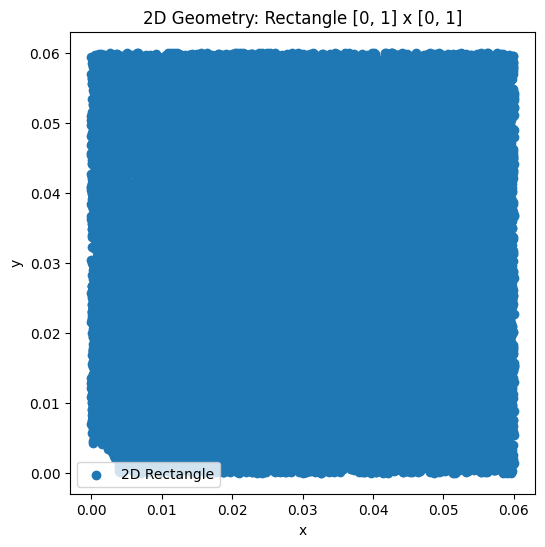

In [42]:
L = 6e-2 #m
R= 4e-3 #m
t_last=1e10 #s
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)

geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [35]:
data_observe = pd.read_excel('Hydrostatic Data with Nodes.xlsx')  # Replace 'Stress.xlsx' with your actual file name
data_observe_sample = data_observe.sample(frac=0.25, random_state=7)  # random_state for reproducibility
x_observe = data_observe_sample[['x', 'y']].values  # Shape (N, 2)
t_observe = np.zeros((x_observe.shape[0], 1))  # Shape (N, 1)
x_observe = np.hstack((x_observe, t_observe))  # Now x_observe has shape (N, 3)
print(x_observe)
sigma_observe = data_observe_sample['sigma'].values.reshape(-1, 1)  # Shape (N, 1)

print(sigma_observe)
train_y = np.hstack((
    np.full((sigma_observe.shape[0], 1), np.nan),  # Unknown C_L values
    sigma_observe                                  # Known sigma values
))
ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial, component=0)

x_observe = np.hstack((x_observe[:, :2], np.zeros((x_observe.shape[0], 1))))  # Assuming t=0 for observations
x_observe = x_observe.astype(np.float32)
sigma_observe = sigma_observe.reshape(-1, 1).astype(np.float32)
def custom_loss(outputs, inputs):
    # Extract predictions at anchor points
    y_pred = outputs
    sigma_observe_tf = tf.constant(sigma_observe, dtype=tf.float32)
    sigma_pred = y_pred[:, 1:2]
    loss = tf.reduce_mean(tf.square(sigma_pred - sigma_observe_tf))
    return loss

def pde_C_L(x, y):
    D_L = 3.8e-11 #m^2/s
    V_H = 2e-6 #m^3/mole
    RT= 8.314*298 #J/mole
    Coe=(D_L*V_H)/(RT)
    C_L=y[:,0:1]

    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)
    CL_x=dde.grad.jacobian( y, x, i=0, j=0)
    CL_y=dde.grad.jacobian( y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    h_sigma_t=dde.grad.jacobian(y,x,i=1,j=2)
    h_sigma_x=dde.grad.jacobian(y,x,i=1,j=0)
    h_sigma_y= dde.grad.jacobian(y,x,i=1,j=1)
    h_sigma_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    h_sigma_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)


    eq1 = (dC_dt - D_L * (CL_xx + CL_yy)+ Coe * (CL_x * h_sigma_x + CL_y * h_sigma_y + C_L * (h_sigma_xx + h_sigma_yy)))
    eq2= h_sigma_t
    return [eq1, eq2]

data = dde.data.TimePDE(
    geomtime,
    pde_C_L, [ic],
    num_domain=1000,
    num_boundary=1000,
    num_initial=1000,
    num_test=1000,
    anchors=x_observe
    )



# Network for C_L
layer_size = [3] + [64] * 5 + [2]  
activation = "tanh"
initializer = "He normal"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-4,loss=["MSE", "MSE",custom_loss])

losshistory, train_state = model.train(epochs=50000, display_every=1000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

[[0.02470379 0.013104   0.        ]
 [0.02672495 0.05201948 0.        ]
 [0.00625629 0.03506087 0.        ]
 ...
 [0.00302461 0.00378332 0.        ]
 [0.00281766 0.00360707 0.        ]
 [0.04592595 0.04403896 0.        ]]
[[ 4.43416634e+07]
 [ 4.36429062e+07]
 [ 4.28343506e+07]
 [-2.88414745e+07]
 [ 4.40934792e+07]
 [ 8.33117447e+07]
 [ 1.16087503e+07]
 [ 4.42770538e+07]
 [ 4.34579544e+07]
 [ 2.41132393e+07]
 [ 1.04244659e+08]
 [ 4.36249504e+07]
 [ 4.36099052e+07]
 [ 1.29935560e+07]
 [-3.75185585e+07]
 [ 4.20609016e+07]
 [ 4.50914955e+07]
 [ 5.08017044e+07]
 [ 7.30540314e+07]
 [ 4.36186218e+07]
 [ 6.59343491e+07]
 [ 4.30454559e+07]
 [ 4.35097122e+07]
 [ 4.42340698e+07]
 [ 4.31616211e+07]
 [ 4.34013519e+07]
 [ 4.42245522e+07]
 [ 4.38630714e+07]
 [ 4.34419441e+07]
 [ 3.05314407e+07]
 [ 4.34896469e+07]
 [-9.75769520e+06]
 [-1.71548138e+07]
 [ 8.78973312e+07]
 [ 4.01493111e+07]
 [ 4.51072578e+07]
 [ 4.45998344e+07]
 [ 6.81012650e+07]
 [-3.73908539e+07]
 [ 7.58807220e+07]
 [ 4.31333427e+07]

c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.046132 s

Training model...



InvalidArgumentError: Graph execution error:

Detected at node 'sub_152' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\asyncio\base_events.py", line 608, in run_forever
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\asyncio\base_events.py", line 1936, in _run_once
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\asyncio\events.py", line 84, in _run
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 534, in process_one
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
    File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    File "C:\Users\yesda\AppData\Local\Temp\ipykernel_21100\449600963.py", line 71, in <module>
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\utils\internal.py", line 22, in wrapper
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\model.py", line 137, in compile
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\model.py", line 186, in _compile_tensorflow_compat_v1
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\model.py", line 172, in losses
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\data\data.py", line 13, in losses_train
    File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\data\pde.py", line 176, in losses
    File "C:\Users\yesda\AppData\Local\Temp\ipykernel_21100\449600963.py", line 24, in custom_loss
Node: 'sub_152'
Incompatible shapes: [1000,1] vs. [2000,0]
	 [[{{node sub_152}}]]

Original stack trace for 'sub_152':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\asyncio\base_events.py", line 608, in run_forever
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\asyncio\base_events.py", line 1936, in _run_once
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\asyncio\events.py", line 84, in _run
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 534, in process_one
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
  File "C:\Users\yesda\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
  File "C:\Users\yesda\AppData\Local\Temp\ipykernel_21100\449600963.py", line 71, in <module>
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\utils\internal.py", line 22, in wrapper
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\model.py", line 137, in compile
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\model.py", line 186, in _compile_tensorflow_compat_v1
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\model.py", line 172, in losses
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\data\data.py", line 13, in losses_train
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\data\pde.py", line 176, in losses
  File "C:\Users\yesda\AppData\Local\Temp\ipykernel_21100\449600963.py", line 24, in custom_loss
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\ops\math_ops.py", line 1478, in binary_op_wrapper
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\util\dispatch.py", line 1260, in op_dispatch_handler
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\ops\math_ops.py", line 549, in subtract
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\ops\weak_tensor_ops.py", line 142, in wrapper
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 12243, in sub
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\framework\op_def_library.py", line 796, in _apply_op_helper
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\framework\ops.py", line 2652, in _create_op_internal
  File "c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\tensorflow\python\framework\ops.py", line 1160, in from_node_def


In [45]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import pandas as pd

# Define the custom data class for handling PDEs with observational data
class CustomTimePDE(dde.data.Data):
    def __init__(self, geomtime, pde, ic_bcs, observed_data, num_domain, num_boundary, num_initial):
        super().__init__()
        self.geomtime = geomtime
        self.pde = pde
        self.ic_bcs = ic_bcs
        self.observed_data = observed_data  # Tuple of (x_observe, y_observe)
        self.num_domain = num_domain
        self.num_boundary = num_boundary
        self.num_initial = num_initial

        # Generate training data
        self._generate_train_points()

    def _generate_train_points(self):
        # Generate collocation points in the domain
        self.domain_x = self.geomtime.random_points(self.num_domain)
        # Generate boundary points
        self.boundary_x, self.boundary_x_normal = self.geomtime.random_boundary_points(self.num_boundary)
        # Generate initial condition points
        self.initial_x = self.geomtime.random_initial_points(self.num_initial)

        # Combine all training points
        self.train_x_all = np.vstack((self.domain_x, self.boundary_x, self.initial_x, self.observed_data[0]))
        self.train_x_all = self.train_x_all.astype(np.float32)

        # Prepare the corresponding y values (targets)
        num_total = self.train_x_all.shape[0]
        self.train_y_all = np.full((num_total, 2), np.nan, dtype=np.float32)  # Output dimension is 2

        # Observed data indices
        observed_indices = np.arange(num_total - self.observed_data[0].shape[0], num_total)
        self.observed_indices = observed_indices

        # Set observed sigma values
        self.train_y_all[observed_indices, 1] = self.observed_data[1].flatten()

    def train_next_batch(self, batch_size):
        """Generates the next batch of training data."""
        idx = np.random.choice(self.train_x_all.shape[0], batch_size, replace=False)
        return self.train_x_all[idx], self.train_y_all[idx]

    def test(self):
        """Return all test data."""
        return self.train_x_all, self.train_y_all

    def losses(self, targets, outputs, loss_fn, inputs, model):
        # Compute the PDE residuals at domain points
        f = self.pde(inputs[0:self.num_domain], outputs[0:self.num_domain])

        # Loss for PDE residuals
        loss_pde = loss_fn(f[0], 0) + loss_fn(f[1], 0)

        # Loss for boundary and initial conditions
        loss_bcs = 0
        idx = self.num_domain
        for bc in self.ic_bcs:
            # Number of points for this BC
            num_points = bc.num_points
            # Extract inputs and outputs for this BC
            bc_inputs = inputs[idx:idx + num_points]
            bc_outputs = outputs[idx:idx + num_points]
            # Compute the BC residual
            bc_residual = bc.bc_value(bc_inputs, bc_outputs, self)
            # Accumulate the loss
            loss_bcs += loss_fn(bc_residual, 0)
            idx += num_points

        # Loss for observed data
        observed_outputs = outputs[self.observed_indices]
        observed_targets = targets[self.observed_indices]
        mask = ~np.isnan(observed_targets)
        loss_observed = loss_fn(tf.boolean_mask(observed_outputs, mask), tf.boolean_mask(observed_targets, mask))

        # Total loss
        losses = [loss_pde, loss_bcs, loss_observed]
        return losses

# Load and prepare observational data
data_observe = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
data_observe_sample = data_observe.sample(frac=0.25, random_state=7)

# Extract spatial coordinates and time
x_observe = data_observe_sample[['x', 'y']].values  # Shape (N, 2)
t_observe = np.zeros((x_observe.shape[0], 1))       # Assuming observations at t=0
x_observe = np.hstack((x_observe, t_observe))       # Now x_observe has shape (N, 3)

# Extract sigma observations
sigma_observe = data_observe_sample['sigma'].values.reshape(-1, 1)  # Shape (N, 1)

# Prepare observed data tuple
observed_data = (x_observe.astype(np.float32), sigma_observe.astype(np.float32))

# Define the PDE function
def pde_C_L(x, y):
    D_L = 3.8e-11  # m^2/s
    V_H = 2e-6     # m^3/mol
    R = 8.314      # J/(mol·K)
    T = 298        # K
    Coe = (D_L * V_H) / (R * T)

    C_L = y[:, 0:1]
    sigma = y[:, 1:2]

    # Time derivative of C_L
    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)

    # Spatial derivatives of C_L
    CL_x = dde.grad.jacobian(y, x, i=0, j=0)
    CL_y = dde.grad.jacobian(y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    # Spatial derivatives of sigma
    sigma_x = dde.grad.jacobian(y, x, i=1, j=0)
    sigma_y = dde.grad.jacobian(y, x, i=1, j=1)
    sigma_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    sigma_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    # PDE equations
    eq1 = (
        dC_dt
        - D_L * (CL_xx + CL_yy)
        + Coe * (CL_x * sigma_x + CL_y * sigma_y + C_L * (sigma_xx + sigma_yy))
    )
    # Time derivative of sigma (assuming sigma is time-independent)
    eq2 = dde.grad.jacobian(y, x, i=1, j=2)
    return [eq1, eq2]

# Define initial and boundary conditions
ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial, component=0)
ic_bcs = [ic]

# Create an instance of the custom data class
data = CustomTimePDE(
    geomtime=geomtime,
    pde=pde_C_L,
    ic_bcs=ic_bcs,
    observed_data=observed_data,
    num_domain=1000,
    num_boundary=1000,
    num_initial=1000
)

# Define the neural network
layer_size = [3] + [64] * 5 + [2]  # Input: x, y, t; Output: C_L, sigma
activation = "tanh"
initializer = "He normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Create and compile the model
model = dde.Model(data, net)


ValueError: too many values to unpack (expected 2)

In [13]:
p=model.predict([[0.1,0.5,0.5]])
print(p)
p=model.predict([[0.1,0.2,0.8]])
print(p)
p=model.predict([[0.1,0.5,0.7]])
print(p)

[[-1.1920929e-07 -9.8086894e-06 -4.6231556e+00  4.1169830e+01
  -3.9448261e-01  2.0000000e+01]]
[[-1.1920929e-07 -9.8086894e-06 -4.6231556e+00  4.1169830e+01
  -3.9448261e-01  2.0000000e+01]]
[[-1.1920929e-07 -9.8086894e-06 -4.6231556e+00  4.1169830e+01
  -3.9448261e-01  2.0000000e+01]]


In [ ]:

import matplotlib.pyplot as plt
import imageio

# Assume you have already trained the model and now you're making predictions.

# Define the geometry (Square Plate)
L = 6e-2
geom = dde.geometry.Rectangle([0, 0], [L, L])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Set up a grid for prediction (x, y)
x_coords = np.linspace(0, L, 100)
y_coords = np.linspace(0, L, 100)
X, Y = np.meshgrid(x_coords, y_coords)

# Define time steps for the animation
time_steps = np.linspace(0, 1, 100)  # 100 time steps from t=0 to t=1

# Create an array to store predictions for each time step
predictions = np.zeros((len(x_coords), len(y_coords), len(time_steps)))

# Loop over time steps and generate predictions for the model
for t_idx, t in enumerate(time_steps):
    for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
        input_data = np.array([[x, y, t]])
        prediction = model.predict(input_data)[0][0]  # Extract the C_L prediction
        predictions[i % len(x_coords), i // len(x_coords), t_idx] = prediction

# Create and save the animation using imageio
frames = []

for t_idx, t in enumerate(time_steps):
    fig, ax = plt.subplots()
    cax = ax.contourf(X, Y, predictions[:, :, t_idx], levels=100, cmap='viridis')
    ax.set_title(f"Prediction at t={t:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Save the current frame as an image
    fig.canvas.draw()  # Draw the figure so the content is updated
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)  # Close the figure to avoid memory issues

# Save as an animation using imageio
imageio.mimsave('model_prediction_animation.gif', frames, fps=10)

# Alternatively, save as an mp4 using imageio with ffmpeg plugin
imageio.mimsave('model_prediction_animation.mp4', frames, fps=10)


In [ ]:

x_coords=data_observe_sample[['x']].values
y_coords=data_observe_sample[['y']].values

# Load Excel data (or CSV for demonstration purposes)
df = pd.read_excel('hydrogen_concentration.xlsx') 
time = df['time'].values
time=np.array(time.tolist())/1000000
x_coords = np.ravel(np.array(x_coords).reshape([1,-1]))
y_coords = np.ravel(np.array(y_coords).reshape([1,-1]))
time_steps = np.ravel(np.array(time).reshape([1,-1]))  # Example time steps
predictions = np.zeros((len(x_coords), len(y_coords), len(time_steps)))

# Loop through each time step
for t_idx, t in enumerate(time_steps):
    # Loop through all (x, y) combinations
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        input_data = np.array([x, y, t]) 
        # Make the prediction for this (x, y, t) combination
        prediction = model.predict([input_data])[0][0]
        print(f"Prediction for (x={x}, y={y}, t={t}): {prediction}")
        # Extract the scalar prediction value (ensure it's not a sequence)
        predictions[:,i,t_idx]=prediction
        # Store the prediction in the correct location

predictions=np.array(predictions[0]).T        
print(predictions)  

import os
def delete_file(filepath):
    # Check if the file exists
    if os.path.exists(filepath):
        try:
            # Delete the file
            os.remove(filepath)
            print(f"File {filepath} successfully deleted.")
        except Exception as e:
            print(f"Error deleting file {filepath}: {e}")
    else:
        print(f"File {filepath} does not exist.")
filepath = "predictions_output.xlsx"

# Delete the file
delete_file(filepath)

print(predictions)
# Flatten the x_coords and y_coords arrays for labeling the columns
x_coords_flat = np.ravel(x_coords)
y_coords_flat = np.ravel(y_coords)

# Prepare column labels as "(x, y)" pairs
column_labels = [f"node_{i+1}" for i in range(len(x_coords_flat))]

# Create a Pandas DataFrame with time steps as rows and (x, y) as columns
df = pd.DataFrame(predictions, columns=column_labels)

# Add a "Time" column to label the time steps
df.insert(0,"time", (time_steps.flatten())*1000000)

# Export the DataFrame to an Excel file
df.to_excel("predictions_output.xlsx", index=False)

print("Data has been successfully exported to predictions_output.xlsx")


from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the two Excel files, skipping the first row and first column
df1 = pd.read_excel('hydrogen_concentration.xlsx').iloc[2:, 1:]
df2 = pd.read_excel('predictions_output.xlsx').iloc[2:, 1:]

# Ensure the data is aligned by resetting the indices
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# Convert the dataframes to NumPy arrays for easy comparison
data1 = df1.to_numpy()
data2 = df2.to_numpy()

# Calculate similarity metrics
mse = mean_squared_error(data1, data2)
mae = mean_absolute_error(data1, data2)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Optionally, compute element-wise absolute differences
difference = abs(data1 - data2)
print(f"Max Absolute Difference: {difference.max()}")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df3 = pd.read_excel('hydrogen_concentration.xlsx')  # First dataset
df4 = pd.read_excel('predictions_output.xlsx')  # Second dataset



# Heatmap for Dataset 1
plt.figure(figsize=(12, 8))
sns.heatmap(df3.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 1 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

# Heatmap for Dataset 2
plt.figure(figsize=(12, 8))
sns.heatmap(df4.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 2 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

df_diff = df3.set_index('time') - df4.set_index('time')
# Heatmap for the Difference
plt.figure(figsize=(12, 8))
sns.heatmap(df_diff.T, cmap="coolwarm", cbar_kws={'label': 'Difference'})
plt.title("Heatmap of Difference (Dataset 1 - Dataset 2)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

